In [1]:
# importing necessary libraries. 
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# requesting the website with get method of requests module.
# it will return a response object.
url = 'https://wisevoter.com/state-rankings/states-by-population'
response = requests.get(url)

#checking if the response is 200 ok. means we can access the site content.
if response.status_code == 200:
    print('Successfully Connected ! 200 ok')
else:
    print('Wrong Response Try again')

Successfully Connected ! 200 ok


In [3]:
#making a soup object (an instance of BeautifulSoup) to parse the html content of webpage.
soup = BeautifulSoup(response.content,'html.parser')  

**note** - <ul><li><strong>find</strong> used for getting content of only first tag.</li>
    <li><strong>find_all</strong> used for getting content of all tags(repeating) </li></ul>

In [4]:
#there is only one table on this webpage
# we are finding the body element of table tag. because it contain table data.
s = soup.find('tbody')

#### table rows 

In [5]:
# we need to find all the table data <td> which contain individual data values.
table_data = s.find_all('td')  #we have multiple <td> tags.

DATA = []   
for item in table_data:
     DATA.append(str(item.text)) 

# we looped through individual tags. then extracting the text(data) out of tags then appending 
# it to DATA list. 


####  now our DATA looks like this.
        ['1', 'California', '39,237,836', '19,618,918', '19,618,918', '258.21 per mi²', '2', 'Texas', '29,527,941', '14,734,443']
        
 
    ### we need to seperate each rows.
    row1 = DATA[:6] first six values of our list are a single row of the table.
    >>> output = ['1', 'California', '39,237,836', '19,618,918', '19,618,918', '258.21 per mi²']
    
    row2 = DATA[6:12]   second row
    row3 = DATA[12:16]    third row.
    ### we can apply loop to get data of each row.

In [6]:
ROWS = []
for i in range(0,len(DATA),6): #starting with zero index , with a jump of 6 . # 0 6 12 18 ......
    ROWS.append(DATA[i:i+6])   
    
# each rows list will be appending to the ROWS list. it will become nested list(like a 2d matrix) 
#with rows and columns which we can use to convert into dataframe.

#### table headers / columns

In [7]:

s = soup.find('thead') #thead tag contains table headers.
s = s.find_all('th')  #<th> contains individual column headings.
s = list(s)  # change its type to a list.

COLUMNS = [str(item.text).strip() for item in s] #we get the column names.
print(COLUMNS)

['#', 'State', 'Population', 'Male Population', 'Female Population', 'Population Density']


#### DataFrame 

In [8]:
df = pd.DataFrame(data=ROWS,columns=COLUMNS)
df.head() #we get our data in a dataframe.

,#,State,Population,Male Population,Female Population,Population Density
0,1,California,"39,237,836","19,618,918","19,618,918",258.21 per mi²
1,2,Texas,"29,527,941","14,734,443","14,793,498",116.16 per mi²
2,3,Florida,"21,781,128","10,716,315","11,064,813",416.96 per mi²
3,4,New York,"19,835,913","9,699,761","10,136,152",433.9 per mi²
4,5,Pennsylvania,"12,964,056","6,404,244","6,559,812",292.62 per mi²


In [9]:
df.info()  # ever column is oject(string) type . 
# we will change the data type of numerical column to integer or float. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   #                   52 non-null     object
 1   State               52 non-null     object
 2   Population          52 non-null     object
 3   Male Population     52 non-null     object
 4   Female Population   52 non-null     object
 5   Population Density  52 non-null     object
dtypes: object(6)
memory usage: 2.6+ KB


### Data preproccessing.

In [10]:
# we do not require index column as we already have indexes in dataframe.we will drop them
df.drop('#',axis=1,inplace=True)

In [11]:
df[df['Male Population'] == ""]
# few rows have empty values for some columns. 

,State,Population,Male Population,Female Population,Population Density
30,Puerto Rico,"3,263,584",,,


   **either we can drop the rows or fill these with median of their respective columns.**

In [12]:
def convert_to_numerical(x):
    """convert_to_numerical(x) >>> this function takes dataframe individual values
    as arguement then returns it to integer or float. this function will be used inside
    APPLY function of dataframe.
    """
    if x=='':    # some values are empty. 
            return None
    if 'per' in x:     # for the population density column .it needs to process differently. 
        x = x.split()
        x = x[0] 
        if "," in x:
            x = x.split(",")
            return float("".join(x))
    
        else:
            return float(x)
    else:
        x = x.split(",")  # for remaining columns.
        new = "".join(x)
        return int(new)

In [13]:
# but first lets change the data type of the columns.
for column in df:
    #skip first column
    if column == "State":
        continue
    df[column] = df[column].apply(convert_to_numerical)

In [14]:
df.info() # successfully change the datatype . now we can perform mathematical operations 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               52 non-null     object 
 1   Population          52 non-null     int64  
 2   Male Population     51 non-null     float64
 3   Female Population   51 non-null     float64
 4   Population Density  50 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.2+ KB


In [15]:
# checking if some rows have none values , we will fill them with median . 
df.isna().value_counts()
#we have few none values.

State  Population  Male Population  Female Population  Population Density
False  False       False            False              False                 50
                                                       True                   1
                   True             True               True                   1
dtype: int64

In [16]:
for column in df:
    if column == "State":
        continue
    df[column].fillna(value=df[column].median(),inplace=True)

    with this we have complete data data cleaning and pre processing . 

In [17]:
# saving the table to a csv file to working directory. 
df.to_csv('./usa_population.csv',index=False)

In [18]:
df = pd.read_csv('usa_population.csv')
df.head()

,State,Population,Male Population,Female Population,Population Density
0,California,39237836,19618918.0,19618918.0,258.21
1,Texas,29527941,14734443.0,14793498.0,116.16
2,Florida,21781128,10716315.0,11064813.0,416.96
3,New York,19835913,9699761.0,10136152.0,433.90
4,Pennsylvania,12964056,6404244.0,6559812.0,292.62


**note** - population density is in mile per square

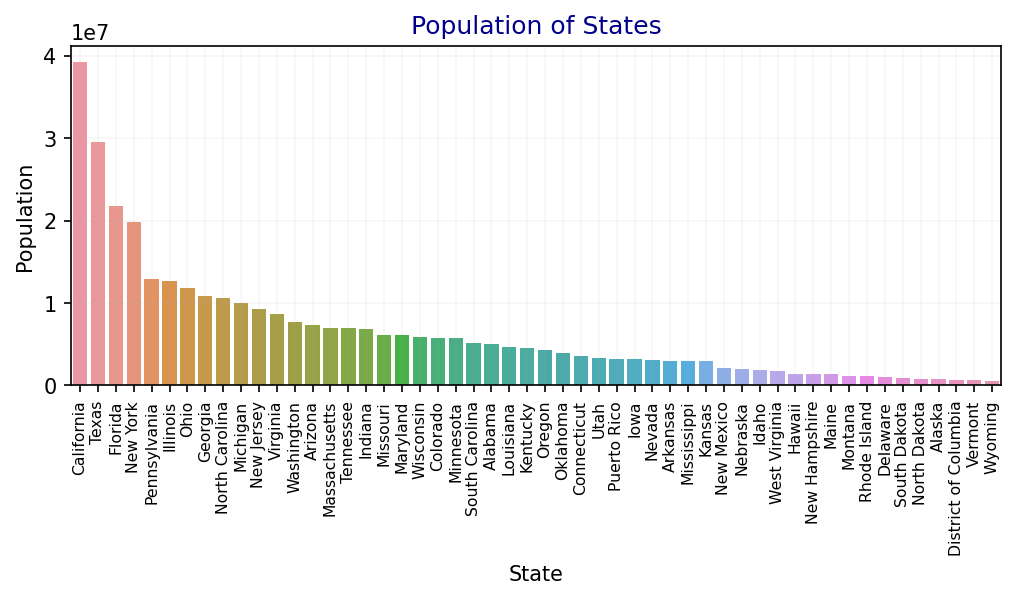

In [20]:
# population of each state . (bar chart)
fig, ax = plt.subplots(dpi=150,figsize=(8,3))
x = df["State"]
height = df["Population"]
sns.barplot(x,height,ax=ax)
plt.xticks(rotation=90,fontsize=7.5)
ax.set_title('Population of States',color='darkblue')
ax.grid(alpha=0.1)
plt.show()

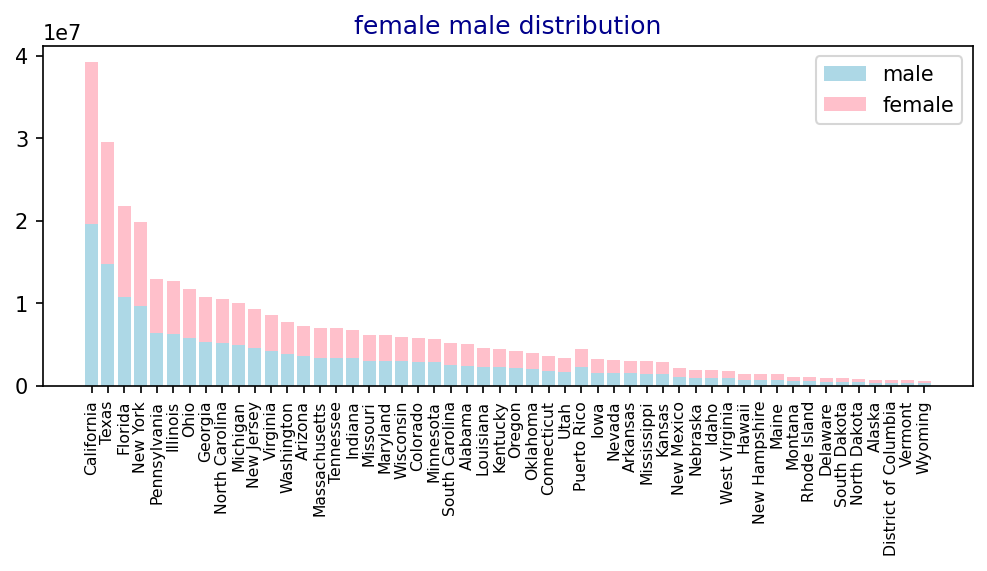

In [21]:
# male female distribution.
fig, ax = plt.subplots(dpi=150,figsize=(8,3))
x = df["State"]
y1 = df["Male Population"]
y2 = df["Female Population"]
ax.bar(x,y1,label='male',color='lightblue')
ax.bar(x,y2,bottom=y1,color='pink',label='female')
plt.xticks(rotation=90,fontsize=7.5)
ax.set_title('female male distribution',color='darkblue')
ax.legend()
plt.show()

In [22]:
distribution = [['female Population', df["Female Population"].sum()],['male population',df["Male Population"].sum()]]
df_dist = pd.DataFrame(distribution)
df_dist

,0,1
0,female Population,169828983.0
1,male population,166574157.0


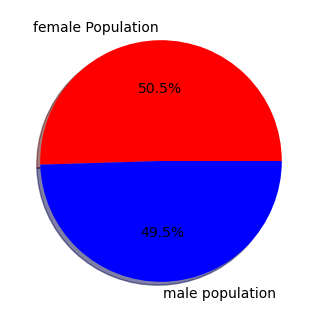

In [23]:
#pie chart showing percentage population of male and female in USA
fig,ax = plt.subplots(dpi=100)
ax.pie(df_dist[1],labels=df_dist[0],colors=['red','blue'],autopct='%1.1f%%',shadow=True)
plt.show()

# impact of population on population density.
if population increase that means population density too will increase . a positive correlation.
.more people will live on the same area. but there is a limit to which this can happen. 
 there is a saturation point .
  

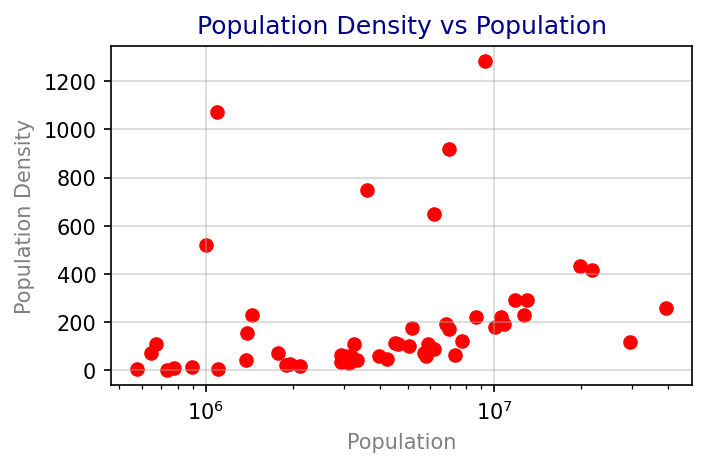

In [24]:
# scatter plot . population density agains population.  
fig,ax = plt.subplots(dpi=150,figsize=(5,3))

ax.scatter(x='Population',y='Population Density',color='red',data=df)
ax.set_xscale('log')  # to normalize the data.
ax.grid(alpha=0.5)
ax.set_title("Population Density vs Population",color='darkblue')
ax.set_xlabel("Population",color='grey')
ax.set_ylabel('Population Density',color='grey')

plt.show()

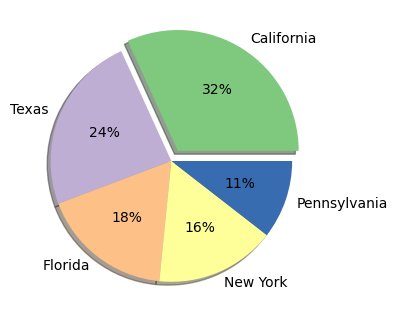

In [25]:
# top five populated states in USA . out of which california is most populated.
new = df[["State","Population"]].sort_values(by='Population',ascending=False)[:5]


fig,ax = plt.subplots(dpi=100)
color_pallete = sns.color_palette('Accent')
ax.pie(new["Population"],labels=new["State"],colors=color_pallete,autopct='%.0f%%',shadow=True
      ,explode=[0.1,0,0,0,0])

plt.show()
#top five most populated states. 

<h1 style="color:Tomato;">&emsp;&emsp;&emsp;done!</h1>